# **Proje Yönetimi: Bireysel Kredi Satış Performansının Optimizasyonu**

In [2]:
from google.colab import files

uploaded = files.upload()

Saving Bank_Personal_Loan_Modelling.csv to Bank_Personal_Loan_Modelling.csv


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy import stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid", palette="muted")


try:
    df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
    print(f"Dosya başarıyla yeniden yüklendi! Toplam Satır Sayısı:{len(df)}")
except FileNotFoundError:
    print("HATA: Dosya bulunamadı!")

Dosya başarıyla yeniden yüklendi! Toplam Satır Sayısı:5000


In [4]:
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv")

df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


In [5]:
df.drop(columns=['ID'], inplace=True)

df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


In [6]:
df.columns

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

In [7]:
df.isnull().any()

,0
Age,False
Experience,False
Income,False
ZIP Code,False
Family,False
CCAvg,False
Education,False
Mortgage,False
Personal Loan,False
Securities Account,False


In [8]:
df.isnull().sum()

,0
Age,0
Experience,0
Income,0
ZIP Code,0
Family,0
CCAvg,0
Education,0
Mortgage,0
Personal Loan,0
Securities Account,0


In [9]:
df['Experience'] = df['Experience'].abs()
df.head()


,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


In [10]:
for col in df.columns:
    if df[col].dtype == 'object':
       df[col] = df[col].astype(str).str.replace(',', '.')
       df[col] = pd.to_numeric(df[col], errors='coerce')

null_data = df.isnull().sum().max()
print(f"\nSilinebilecek potansiyel satır sayısı: {null_data}")

if null_data < 100:
  df.dropna(inplace=True)
  print("Boş değerler içeren satırlar silindi.")

else:
  print("Durun. Bu, büyük veri kaybına neden olacak.")

print(f"\n--- Latest Situation: {len(df)} Row ---")


Silinebilecek potansiyel satır sayısı: 0
Boş değerler içeren satırlar silindi.

--- Latest Situation: 5000 Row ---


/tmp/ipython-input-3762773305.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Durum', y='Basari_Orani', data=analiz, palette=colors)


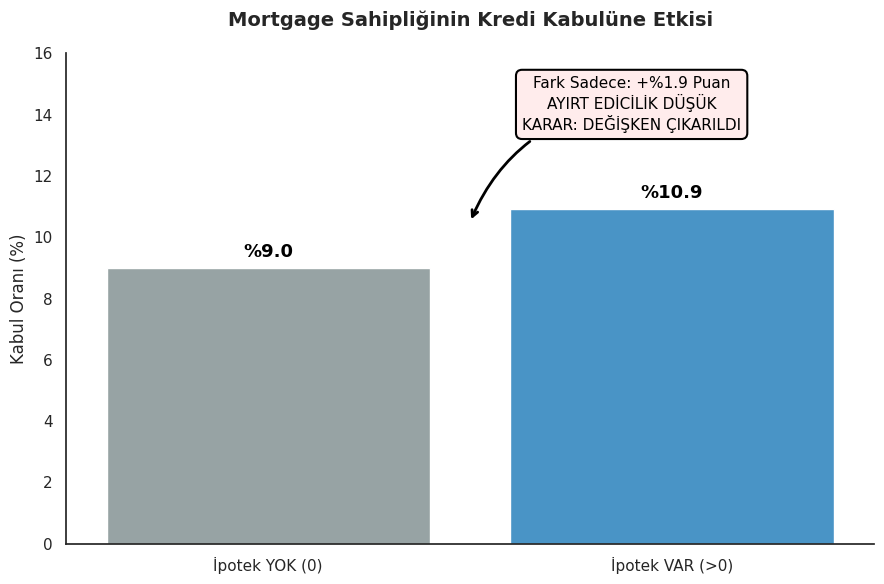

In [11]:
# 2. İPOTEK AYIRT EDİCİLİK KONTROLÜ
# Mortgage'ı olanlar ve olmayanlar (0 olanlar) arasında satış farkı var mı?

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# VERİ HAZIRLIĞI
df['Mortgage_Durumu'] = df['Mortgage'].apply(lambda x: 'İpotek VAR (>0)' if x > 0 else 'İpotek YOK (0)')

analiz = df.groupby('Mortgage_Durumu')['Personal Loan'].mean() * 100
analiz = analiz.reset_index()
analiz.columns = ['Durum', 'Basari_Orani']

analiz = analiz.sort_values(by='Durum', ascending=False)

# GÖRSELLEŞTİRME
sns.set_style("white")
plt.figure(figsize=(9, 6))
colors = ['#95a5a6', '#3498db']

ax = sns.barplot(x='Durum', y='Basari_Orani', data=analiz, palette=colors)

plt.title('Mortgage Sahipliğinin Kredi Kabulüne Etkisi', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Kabul Oranı (%)', fontsize=12)
plt.xlabel('')
plt.ylim(0, 16)

for p in ax.patches:
    ax.annotate(f'%{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=13, fontweight='bold', color='black', xytext=(0, 5),
                textcoords='offset points')

# -KARAR NOTUNU GRAFİĞE EKLEME
fark = analiz.iloc[1, 1] - analiz.iloc[0, 1]

ax.annotate(f'Fark Sadece: +%{fark:.1f} Puan\nAYIRT EDİCİLİK DÜŞÜK\nKARAR: DEĞİŞKEN ÇIKARILDI',
            xy=(0.5, 10.5), xycoords='data',
            xytext=(0.9, 13.5), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.3", color='black', lw=2),
            bbox=dict(boxstyle="round,pad=0.4", fc="#ffecec", ec="black", lw=1.5),
            fontsize=11, color='black', ha='center')

sns.despine()

plt.tight_layout()
plt.show()

In [12]:
df.drop(columns=['Mortgage_Durumu'], inplace=True)

df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


In [13]:
df.describe

<bound method NDFrame.describe of       Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0      25           1      49     91107       4   1.60          1         0   
1      45          19      34     90089       3   1.50          1         0   
2      39          15      11     94720       1   1.00          1         0   
3      35           9     100     94112       1   2.70          2         0   
4      35           8      45     91330       4   1.00          2         0   
...   ...         ...     ...       ...     ...    ...        ...       ...   
4995   29           3      40     92697       1   1.90          3         0   
4996   30           4      15     92037       4   0.40          1        85   
4997   63          39      24     93023       2   0.30          3         0   
4998   65          40      49     90034       3   0.50          2         0   
4999   28           4      83     92612       3   0.80          1         0   

      Personal Loan  Securities Account  CD Account  Online  CreditCard  
0                 0                   1           0       0           0  
1                 0                   1           0       0           0  
2                 0                   0           0       0           0  
3                 0                   0           0       0           0  
4                 0                   0           0       0           1  
...             ...                 ...         ...     ...         ...  
4995              0                   0           0       1           0  
4996              0                   0           0       1           0  
4997              0                   0           0       0           0  
4998              0                   0           0       1           0  
4999              0                   0           0       1           1  

[5000 rows x 13 columns]>

In [14]:
df = df.reset_index(drop=True)
df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.00,2,0,0,0,0,0,1


In [15]:
istatistik_veri = ['Age', 'Experience', 'Income', 'CCAvg']

ist_sum = {}

for col in istatistik_veri:
   ist_sum[col] = {
        'Mean': df[col].mean(),
        'Median': df[col].median(),
        'Mode': df[col].mode()[0],
        'Std': df[col].std(),
        'Min': df[col].min(),
        'Max': df[col].max()
    }

df_ist = pd.DataFrame(ist_sum).T.round(2)

print("--- BASIC STATISTICAL REPORT---")
print(df_ist)

--- BASIC STATISTICAL REPORT---
            Mean  Median  Mode   Std   Min    Max
Age        45.34   45.00 35.00 11.46 23.00  67.00
Experience 20.13   20.00 32.00 11.42  0.00  43.00
Income     73.77   64.00 44.00 46.03  8.00 224.00
CCAvg       1.94    1.50  0.30  1.75  0.00  10.00


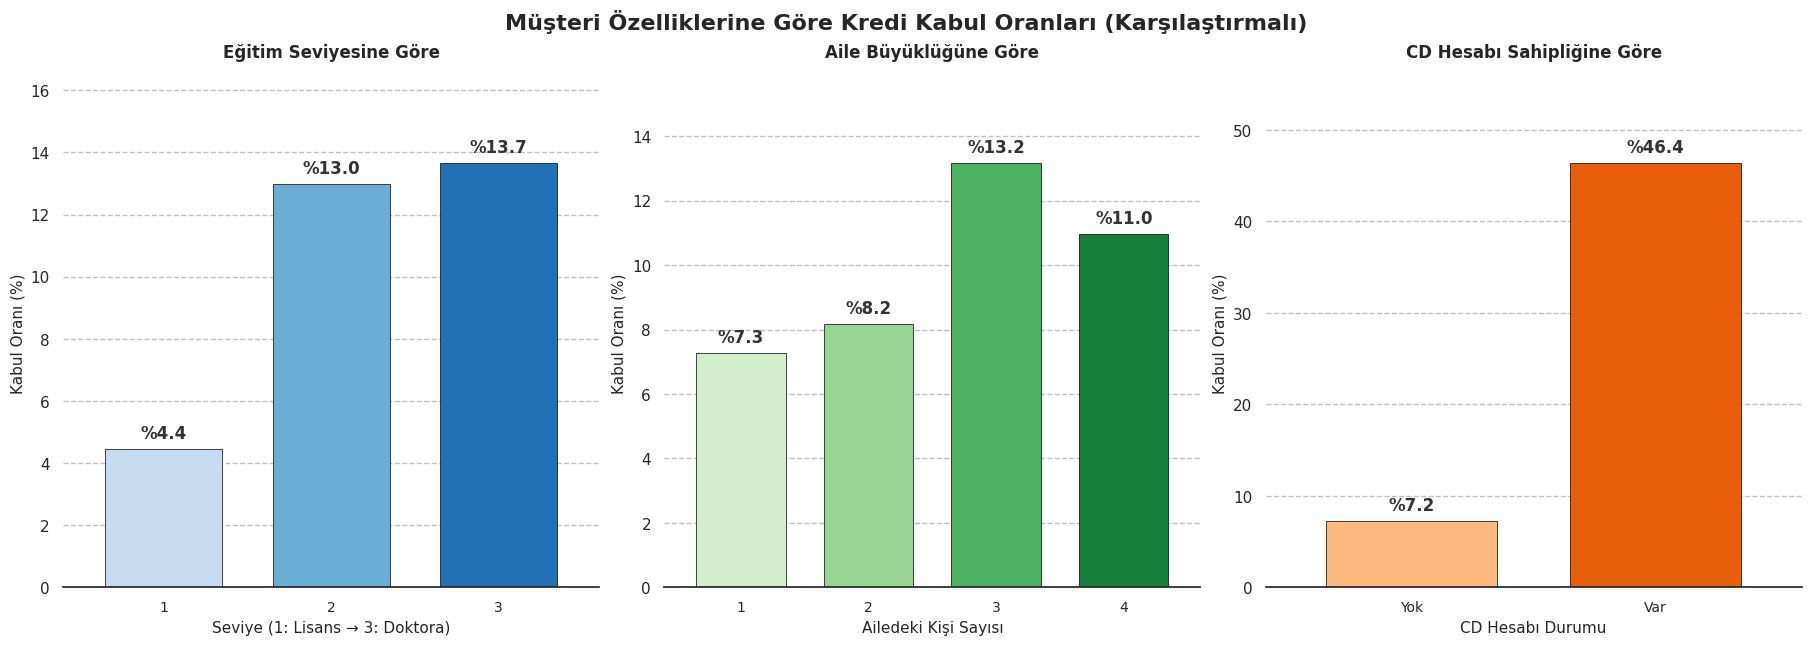

In [16]:
# VERİ HAZIRLIĞI
# Eğitim
edu = df.groupby('Education')['Personal Loan'].mean() * 100
# Aile
fam = df.groupby('Family')['Personal Loan'].mean() * 100
# CD Hesabı
cd_hesap = df.groupby('CD Account')['Personal Loan'].mean() * 100

# GÖRSELLEŞTİRME AYARLARI

sns.set_style("white")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

fig.suptitle('Müşteri Özelliklerine Göre Kredi Kabul Oranları (Karşılaştırmalı)',
             fontsize=16, fontweight='bold', y=1.05)

# FONKSİYON: Grafik
def grafik_ciz(ax, data, title, xlabel, color_palette, x_labels=None):
    colors = sns.color_palette(color_palette, n_colors=len(data))

    data.plot(kind='bar', ax=ax, color=colors, edgecolor='black', linewidth=0.5, width=0.7)

    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel('Kabul Oranı (%)', fontsize=11)
    ax.set_ylim(0, max(data) * 1.2)

    if x_labels:
        ax.set_xticklabels(x_labels, rotation=0, fontsize=10)
    else:
        ax.tick_params(axis='x', rotation=0, labelsize=10)

    ax.grid(axis='y', linestyle='--', alpha=0.5, color='gray')

    sns.despine(ax=ax, left=True)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'%{height:.1f}',
                    (x + width/2, height),
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold', color='#333333',
                    xytext=(0, 5), textcoords='offset points')

# 3. GRAFİKLER

# GRAFİK 1: EĞİTİM
grafik_ciz(axes[0], edu,
           'Eğitim Seviyesine Göre',
           'Seviye (1: Lisans → 3: Doktora)',
           'Blues')

# GRAFİK 2: AİLE BÜYÜKLÜĞÜ
grafik_ciz(axes[1], fam,
           'Aile Büyüklüğüne Göre',
           'Ailedeki Kişi Sayısı',
           'Greens')

# GRAFİK 3: CD HESABI
grafik_ciz(axes[2], cd_hesap,
           'CD Hesabı Sahipliğine Göre',
           'CD Hesabı Durumu',
           'Oranges',
           x_labels=['Yok', 'Var'])

# Göster
plt.show()

/tmp/ipython-input-3378351141.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index='Gelir_Grubu', columns='Education', values='Personal Loan', aggfunc='mean') * 100


--- STRATEJİK HEDEFLER TABLOSU (%) ---
Education       1      2      3
Gelir_Grubu                    
0-50k        0.00   0.00   0.00
50k-100k     1.90   2.60   2.30
100k-150k    9.30  65.90  61.80
150k+       12.80 100.00 100.00


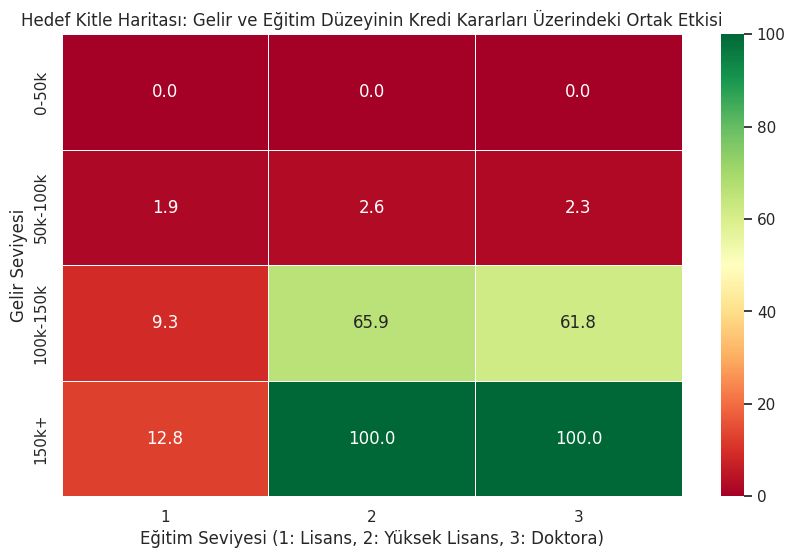

In [27]:
# 3. PIVOT TABLO (Çok Değişkenli Analiz)
# Satırlar: Gelir Grubu
# Sütunlar: Eğitim Seviyesi (1: Lisans, 2: Yüksek Lisans, 3: Doktora)
# Değerler: Kredi Alma Oranı (Ortalama)
df['Gelir_Grubu'] = pd.cut(df['Income'], bins=[0, 50, 100, 150, df['Income'].max()], labels=['0-50k', '50k-100k', '100k-150k', '150k+'])
pivot_table = df.pivot_table(index='Gelir_Grubu', columns='Education', values='Personal Loan', aggfunc='mean') * 100

print("--- STRATEJİK HEDEFLER TABLOSU (%) ---")
print(pivot_table.round(1))

# 4. ISI HARİTASI
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='RdYlGn', linewidths=.5)

plt.title('Hedef Kitle Haritası: Gelir ve Eğitim Düzeyinin Kredi Kararları Üzerindeki Ortak Etkisi')
plt.ylabel('Gelir Seviyesi')
plt.xlabel("Eğitim Seviyesi (1: Lisans, 2: Yüksek Lisans, 3: Doktora)")
plt.show()

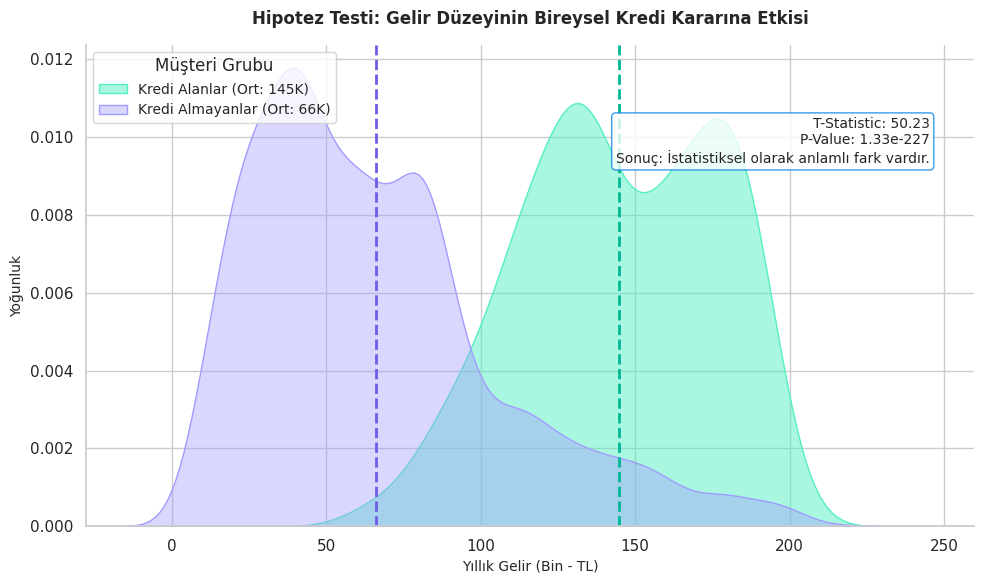

In [28]:
# VERİ VE TEST
grup_1 = df[df['Personal Loan'] == 1]['Income']
grup_0 = df[df['Personal Loan'] == 0]['Income']

# İstatistiksel Test
t_stat, p_val = stats.ttest_ind(grup_1, grup_0, equal_var=False)

# GÖRSELLEŞTİRME
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# İki grubun dağılımı
sns.kdeplot(grup_1, fill=True, color='#55efc4', label='Kredi Alanlar (Ort: {:.0f}K)'.format(grup_1.mean()), alpha=0.5)
sns.kdeplot(grup_0, fill=True, color='#a29bfe', label='Kredi Almayanlar (Ort: {:.0f}K)'.format(grup_0.mean()), alpha=0.4)

# Ortalamalar - Dikey Çizgiler
plt.axvline(grup_1.mean(), color='#00b894', linestyle='--', linewidth=2)
plt.axvline(grup_0.mean(), color='#6c5ce7', linestyle='--', linewidth=2)

# İSTATİSTİKSEL SONUÇ
sonuc_mesaji = "İstatistiksel olarak anlamlı fark vardır." if p_val < 0.05 else "İstatistiksel olarak anlamlı fark yoktur."
renk = "#0984e3" if p_val < 0.05 else "red"

text_str = (f"T-Statistic: {t_stat:.2f}\n"
            f"P-Value: {p_val:.2e}\n"
            f"Sonuç: {sonuc_mesaji}")

plt.gca().text(0.95, 0.85, text_str, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=renk))

# BAŞLIK VE EKSENLER
plt.title('Hipotez Testi: Gelir Düzeyinin Bireysel Kredi Kararına Etkisi', fontsize=12, fontweight='bold', pad=15)
plt.xlabel('Yıllık Gelir (Bin - TL)', fontsize=10)
plt.ylabel('Yoğunluk', fontsize=10)
plt.legend(title='Müşteri Grubu', loc='upper left', fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()


---Gelir Gruplarına Göre Olasılık Analizi---
Gelir_Grubu
0-50k        0.00
50k-100k     2.24
100k-150k   28.57
150k+       49.32
Name: Personal Loan, dtype: float64


/tmp/ipython-input-1383669768.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmentasyon = df.groupby('Gelir_Grubu')['Personal Loan'].mean() * 100
/tmp/ipython-input-1383669768.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=segmentasyon.index, y=segmentasyon.values, palette=colors, edgecolor='black', linewidth=0.5)


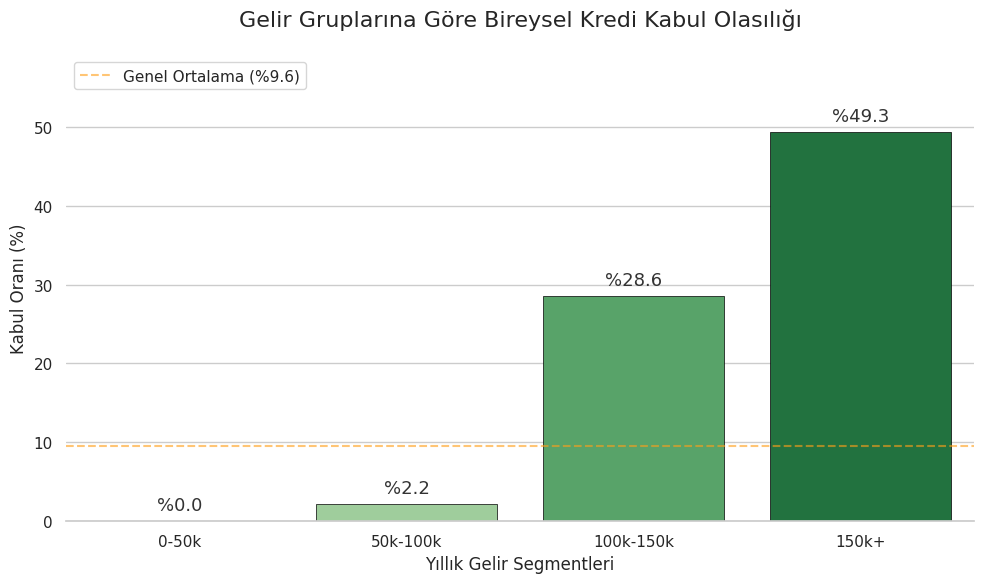

In [29]:
# Gelir Gruplarına Göre Olasılık Analizi

print("\n---Gelir Gruplarına Göre Olasılık Analizi---")

segmentasyon = df.groupby('Gelir_Grubu')['Personal Loan'].mean() * 100
print(segmentasyon)

# GÖRSELLEŞTİRME

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

colors = sns.color_palette("Greens", n_colors=len(segmentasyon))

ax = sns.barplot(x=segmentasyon.index, y=segmentasyon.values, palette=colors, edgecolor='black', linewidth=0.5)

plt.title('Gelir Gruplarına Göre Bireysel Kredi Kabul Olasılığı', fontsize=16, fontweight='normal', pad=20)
plt.ylabel('Kabul Oranı (%)', fontsize=12)
plt.xlabel('Yıllık Gelir Segmentleri', fontsize=12)

plt.ylim(0, segmentasyon.max() * 1.2)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'%{height:.1f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=13, fontweight='normal', color='#333333',
                xytext=(0, 5), textcoords='offset points')

genel_ort = df['Personal Loan'].mean() * 100
plt.axhline(y=genel_ort, color='#ff9f1a', linestyle='--', alpha=0.6, label=f'Genel Ortalama (%{genel_ort:.1f})')
plt.legend(loc='upper left')

sns.despine(left=True)
plt.tight_layout()
plt.show()

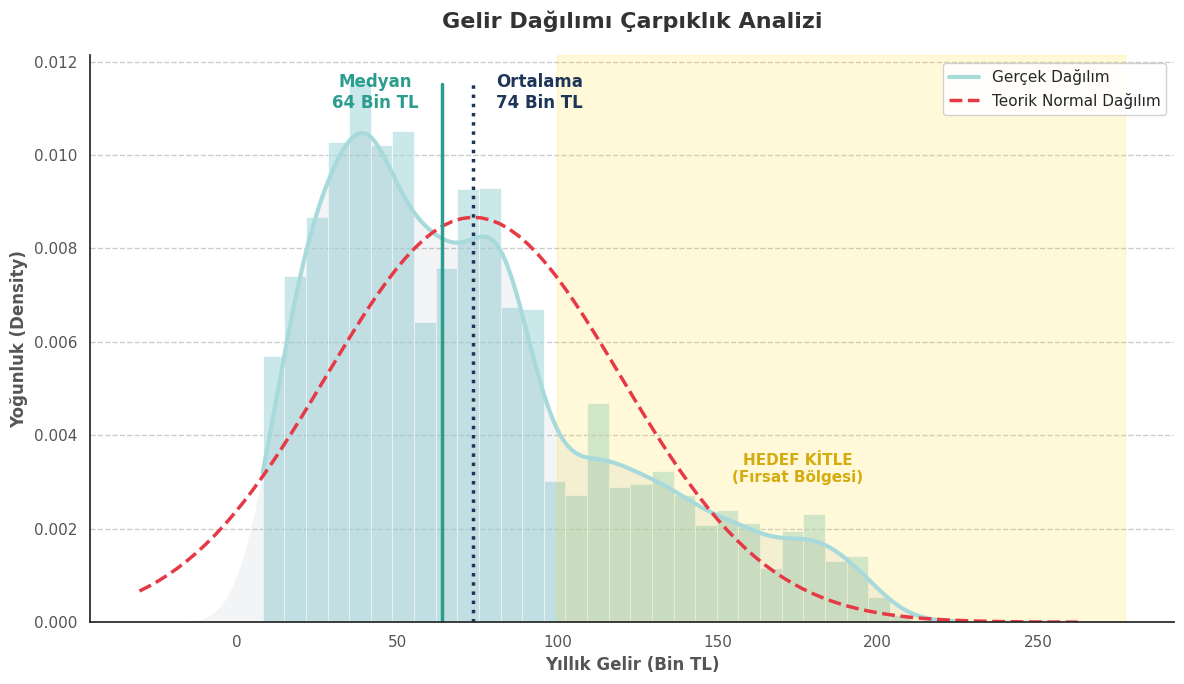

In [41]:
# GELİR DAĞILIMI ÇARPIKLIK ANALİZİ

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

# 1. RENK PALETİ
renk_hist = '#A8DADC'    # Açık Pastel Mavi (Barlar)
renk_kde = '#1D3557'     # Koyu Lacivert (Gerçek Dağılım Çizgisi)
renk_norm = '#E63946'    # Yumuşak Kırmızı (Teorik Normal Çizgisi)
renk_medyan = '#2A9D8F'  # Pastel Yeşil (Medyan/Ortalama)
renk_yazi = '#555555'    # Koyu Gri
renk_zemin = '#F1FAEE'   # Açık zemin rengi

plt.figure(figsize=(12, 7))
sns.set_style("white")

# 2. HISTOGRAM VE GERÇEK DAĞILIM
ax = sns.histplot(df['Income'], kde=True, stat='density',
                  color=renk_hist, alpha=0.6, edgecolor='white', linewidth=0.5,
                  line_kws={'color': renk_kde, 'linewidth': 3, 'label': 'Gerçek Dağılım'})

sns.kdeplot(df['Income'], color=renk_kde, fill=True, alpha=0.05, linewidth=0)


# 3. TEORİK NORMAL DAĞILIM
mu, std = df['Income'].mean(), df['Income'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, color=renk_norm, linestyle='--', linewidth=2.5, label='Teorik Normal Dağılım')

mean_val = df['Income'].mean()
median_val = median_val = df['Income'].median()

plt.axvline(median_val, color=renk_medyan, linestyle='-', linewidth=2.5, ymax=0.95)
plt.text(median_val - 21, 0.011, f'Medyan\n{median_val:.0f} Bin TL', color=renk_medyan, fontweight='bold', ha='center')

plt.axvline(mean_val, color=renk_kde, linestyle=':', linewidth=2.5, ymax=0.95)
plt.text(mean_val + 7, 0.011, f'Ortalama\n{mean_val:.0f} Bin TL', color=renk_kde, fontweight='bold')


# 5. FIRSAT BÖLGESİ (SARI ALAN)
current_xlim = plt.xlim()

plt.axvspan(100, current_xlim[1], color='#FFD700', alpha=0.15)
plt.text(175, 0.003, "HEDEF KİTLE\n(Fırsat Bölgesi)", color='#D4AC0D', fontsize=11, fontweight='bold', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.4, color='gray')
plt.ylabel('Yoğunluk (Density)', fontsize=12, color=renk_yazi, fontweight='bold')
plt.xlabel('Yıllık Gelir (Bin TL)', fontsize=12, color=renk_yazi, fontweight='bold')
plt.tick_params(axis='both', colors=renk_yazi, labelsize=11)

plt.title('Gelir Dağılımı Çarpıklık Analizi', fontsize=16, fontweight='bold', color='#333333', pad=20)
plt.legend(frameon=True, loc='upper right', facecolor='white', framealpha=0.9)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-297406852.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Etki Gücü Skoru', y='Değişken Adı', data=df_ozet, palette=renkler, edgecolor='none')


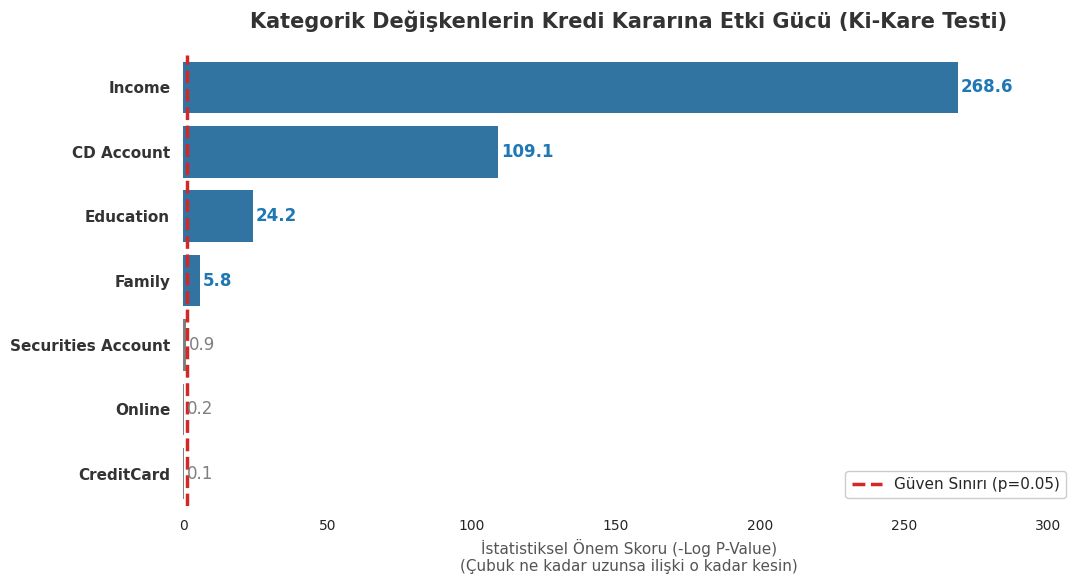

In [77]:
# Kİ KARE TESTİ

from scipy.stats import chi2_contingency

# 1. VERİ HAZIRLIĞI
kategorik_sutunlar = ['Income','Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
test_sonuclari = []

for degisken in kategorik_sutunlar:
    capraz_tablo = pd.crosstab(df[degisken], df['Personal Loan'])
    ki2, p_degeri, serbestlik, beklenen = chi2_contingency(capraz_tablo)
    p_degeri = max(p_degeri, 1e-300)
    onem_skoru = -np.log10(p_degeri)

    test_sonuclari.append({
        'Değişken Adı': degisken,
        'Etki Gücü Skoru': onem_skoru,
        'İlişki Durumu': 'VAR' if p_degeri < 0.05 else 'YOK'
    })

df_ozet = pd.DataFrame(test_sonuclari).sort_values(by='Etki Gücü Skoru', ascending=False)
esik_deger = -np.log10(0.05)


# 2. GÖRSELLEŞTİRME
plt.figure(figsize=(11, 6)) # Biraz daha geniş
sns.set_style("whitegrid") # Sadece yatay ızgara için

renk_guclu = '#1f77b4'  # Tok Kurumsal Mavi
renk_zayif = '#7f7f7f'  # Net Koyu Gri
renk_cizgi = '#d62728'  # Belirgin Kırmızı

renkler = [renk_guclu if durum == 'VAR' else renk_zayif for durum in df_ozet['İlişki Durumu']]

# Ana Grafik
ax = sns.barplot(x='Etki Gücü Skoru', y='Değişken Adı', data=df_ozet, palette=renkler, edgecolor='none')
ax.set_xlim(0, df_ozet['Etki Gücü Skoru'].max() * 1.15) # %15 boşluk bırak

# 3. DETAYLAR
# Eşik Çizgisi
plt.axvline(esik_deger, color=renk_cizgi, linestyle='--', linewidth=2.5,
            label=f'Güven Sınırı (p=0.05)')

# Başlık ve Eksenler
plt.title('Kategorik Değişkenlerin Kredi Kararına Etki Gücü (Ki-Kare Testi)', fontsize=15, fontweight='bold', color='#333333', pad=20)
plt.xlabel('İstatistiksel Önem Skoru (-Log P-Value)\n(Çubuk ne kadar uzunsa ilişki o kadar kesin)', fontsize=11, color='#555555')
plt.ylabel('')
plt.xticks(fontsize=10)
plt.yticks(fontsize=11, fontweight='bold', color='#333333')

# Çubukların Ucuna Değerleri Yazma
for i, cubuk in enumerate(ax.patches):
    genislik = cubuk.get_width()
    anlamli_mi = df_ozet.iloc[i]['İlişki Durumu'] == 'VAR'

    # Etiket Rengi
    yazi_rengi = renk_guclu if anlamli_mi else renk_zayif
    # Font Kalınlığı
    font_kalinligi = 'bold' if anlamli_mi else 'normal'

    ax.text(genislik + 1, cubuk.get_y() + cubuk.get_height()/2,
            f'{genislik:.1f}',  # Örn: "109.2"
            ha='left', va='center',
            color=yazi_rengi, fontweight=font_kalinligi, fontsize=12)

plt.legend(loc='lower right', frameon=True, facecolor='white', framealpha=1)
sns.despine(left=True, bottom=True) # Sol ve alt çizgileri kaldır
plt.grid(axis='x') # Sadece dikey grid çizgilerini kaldır

plt.tight_layout()
plt.show()

/tmp/ipython-input-1792164304.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Segment', y='Basari_Orani', data=df_final, palette=list(df_final['Renk']))


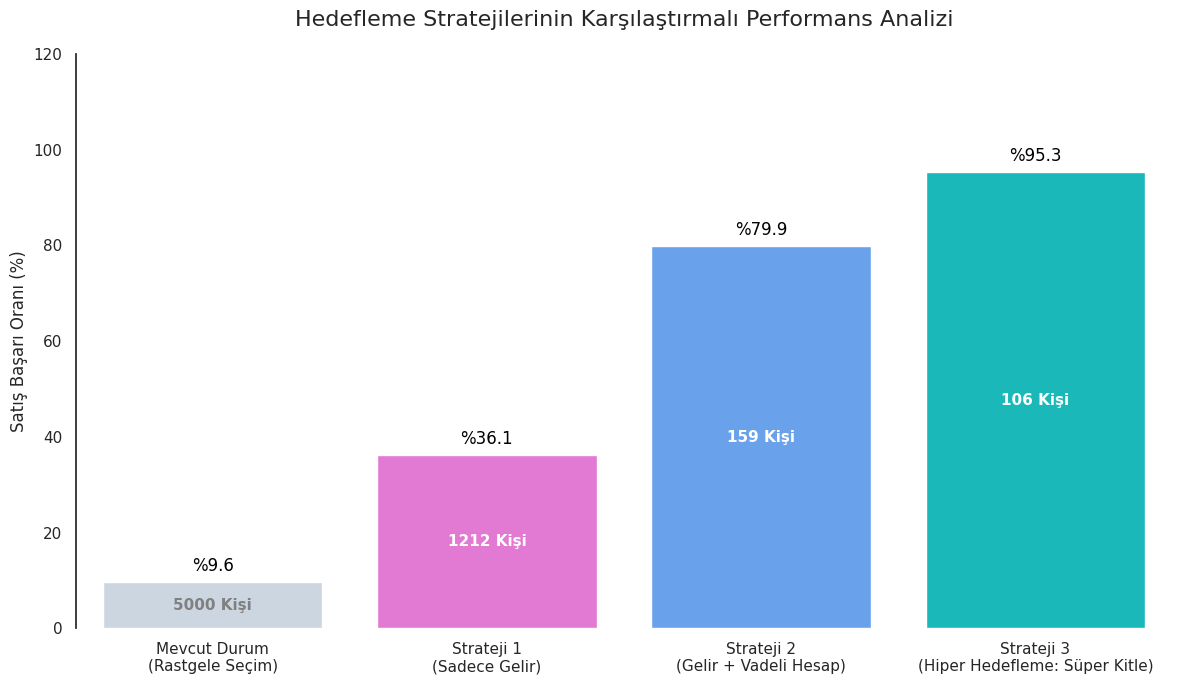

In [43]:
# SEGMENTASYON (Kural Bazlı Seçim)
# Geliri yüksek, eğitim düzeyi yüksek ve vadeli hesabı olanlar krediye daha meyilli.

# Mevcut Durum
baseline_rate = df['Personal Loan'].mean() * 100
baseline_count = len(df)

# 1. SENARYO (Sadece Gelir)
mask_bronz = df['Income'] > 100
kitle_bronz = df[mask_bronz]

# 2. SENARYO (Gelir + CD Account)
mask_gumus = (df['Income'] > 100) & (df['CD Account'] > 0)
kitle_gumus = df[mask_gumus]

# 3. SENARYO (Gelir + Yüksek Eğitim + CD Hesabı)
mask_altin = (df['Income'] > 100) & (df['Education'] > 1) & (df['CD Account'] == 1)
kitle_altin = df[mask_altin]

data_karsilastirma = {
    'Segment': [
        'Mevcut Durum\n(Rastgele Seçim)',
        'Strateji 1\n(Sadece Gelir)',
        'Strateji 2\n(Gelir + Vadeli Hesap)',
        'Strateji 3\n(Hiper Hedefleme: Süper Kitle)'
    ],
    'Basari_Orani': [
        baseline_rate,
        kitle_bronz['Personal Loan'].mean() * 100,
        kitle_gumus['Personal Loan'].mean() * 100,
        kitle_altin['Personal Loan'].mean() * 100
    ],
    'Musteri_Sayisi': [
        baseline_count,
        len(kitle_bronz),
        len(kitle_gumus),
        len(kitle_altin)
    ],

    'Renk': ['#c8d6e5', '#f368e0', '#54a0ff', '#00d2d3'] # Gri, Mavi, Mor, Altın Sarısı
}

df_final = pd.DataFrame(data_karsilastirma)


# GÖRSELLEŞTİRME
plt.figure(figsize=(12, 7))
sns.set_style("white")

ax = sns.barplot(x='Segment', y='Basari_Orani', data=df_final, palette=list(df_final['Renk']))

plt.title('Hedefleme Stratejilerinin Karşılaştırmalı Performans Analizi', fontsize=16, fontweight='normal', pad=20)
plt.ylabel('Satış Başarı Oranı (%)', fontsize=12)
plt.xlabel('')
plt.ylim(0, 120)

# Detaylar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    count = df_final.loc[i, 'Musteri_Sayisi']


    ax.annotate(f'%{height:.1f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12, fontweight='normal', color='black',
                xytext=(0, 5), textcoords='offset points')

    text_color = 'white' if height > 15 else 'gray'
    ax.text(p.get_x() + p.get_width()/2., height/2,
            f'{count} Kişi',
            ha='center', va='center', fontsize=11, color=text_color, fontweight='bold')

sns.despine(bottom=True)
plt.tight_layout()
plt.show()



Lojistik Regresyon Sonuçları
Doğruluk (Accuracy): 0.8960

Detaylı Rapor:

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       904
           1       0.48      0.93      0.63        96

    accuracy                           0.90      1000
   macro avg       0.73      0.91      0.79      1000
weighted avg       0.94      0.90      0.91      1000



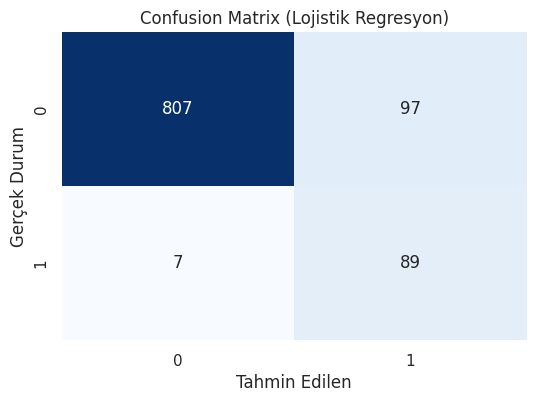

In [65]:
# MAKİNE ÖĞRENMESİ (ML)
# LOJİSTİK REGRESYON

# 1. HEDEF VE DEĞİŞKENLERİ BELİRLEME
X = df.drop(['ZIP Code', 'Personal Loan','Gelir_Grubu'], axis=1)
y = df['Personal Loan'] # Bireysel kredi değişkeni hedef. Bu yüzden x'den çıkarıp, y yani hedef olarak yazılmalıdır.

# 2. EĞİTİM VE TEST SETİNE AYIRMA (%80 Eğitim, %20 Test)
#Stratify, dengesiz verilerde dengeyi sağlamak için kullanılır. -Üzümlü kek teorisi-
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. VERİYİ ÖLÇEKLEME (SCALING)
# Gelir 100 binlerdeyken, Eğitim 1-2-3 diye gidiyor. Hepsini aynı standarta getiriyoruz.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. MODELİ KURMA (Lojistik Regresyon)
# class_weight='balanced' - çünkü veri setinde kredi alanlar azınlıkta. Model buna dikkat etmeli.
log_model = LogisticRegression(random_state=42, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)

# 5. TAHMİN YAPMA
y_pred = log_model.predict(X_test_scaled)

# 6. SONUÇLARI GÖRME
print("Lojistik Regresyon Sonuçları")
print(f"Doğruluk (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print("\nDetaylı Rapor:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Lojistik Regresyon)')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Durum')
plt.show()

Random Forest Sonuçları
Doğruluk (Accuracy): %99.10

Detaylı Rapor:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       904
           1       0.97      0.94      0.95        96

    accuracy                           0.99      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.99      0.99      0.99      1000



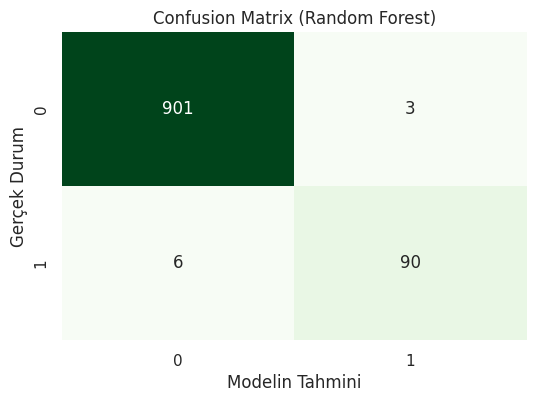

In [69]:
# RANDOM FOREST
#  1. MODELİ KURMA

# n_estimators=100 -> 100 tane karar ağacı
# random_state=42 -> Her seferinde aynı sonucu versin.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. EĞİTİM
rf_model.fit(X_train_scaled, y_train)

# 3. TAHMİN
y_pred_rf = rf_model.predict(X_test_scaled)

# 4. SONUÇLARI GÖRME
print("Random Forest Sonuçları")
print(f"Doğruluk (Accuracy): %{accuracy_score(y_test, y_pred_rf)*100:.2f}")
print("\nDetaylı Rapor:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 4))
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Gerçek Durum')
plt.xlabel('Modelin Tahmini')
plt.show()

In [83]:
from sklearn.model_selection import cross_val_score

# MODELİN DOĞRULUĞUNUN TEST EDİLMESİ

# 1. TEST: TRAIN vs TEST SKORLARI
train_score = rf_model.score(X_train_scaled, y_train)
test_score = rf_model.score(X_test_scaled, y_test)

print(f"Eğitim Seti Başarısı: %{train_score*100:.2f}")
print(f"Test Seti Başarısı:   %{test_score*100:.2f}")

if train_score - test_score > 0.10:
    print("SONUÇ: DİKKAT! Model ezberlemiş -overfitting- olabilir. Fark %10'dan büyük.")
else:
    print("SONUÇ: TEMİZ. Eğitim ve Test sonuçları birbirine yakın, ezberleme görünmüyor.")

print("\n" + "-"*30 + "\n")

# 2. TEST: 5 KATLI ÇAPRAZ DOĞRULAMA (CROSS VALIDATION)
# Veriyi 5 kez karıştırıp tekrar tekrar test edilmesi
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)

print(f"5 Katlı Çapraz Doğrulama: {cv_scores}")
print(f"Ortalama Başarı:   %{cv_scores.mean()*100:.2f}")
print(f"Standart Sapma:    {cv_scores.std():.4f}")

if cv_scores.min() > 0.95:
    print("\nGENEL YORUM: TEMİZ. Ezberleme tespit edilmedi.")
else:
    print("\nGENEL YORUM: DİKKAT! Sonuçlar değişkenlik gösteriyor, ezberleme olabilir.")

Eğitim Seti Başarısı: %100.00
Test Seti Başarısı:   %99.10
SONUÇ: TEMİZ. Eğitim ve Test sonuçları birbirine yakın, ezberleme görünmüyor.

------------------------------

5 Katlı Çapraz Doğrulama: [0.98875 0.98625 0.98    0.98    0.985  ]
Ortalama Başarı:   %98.40
Standart Sapma:    0.0035

GENEL YORUM: TEMİZ. Ezberleme tespit edilmedi.


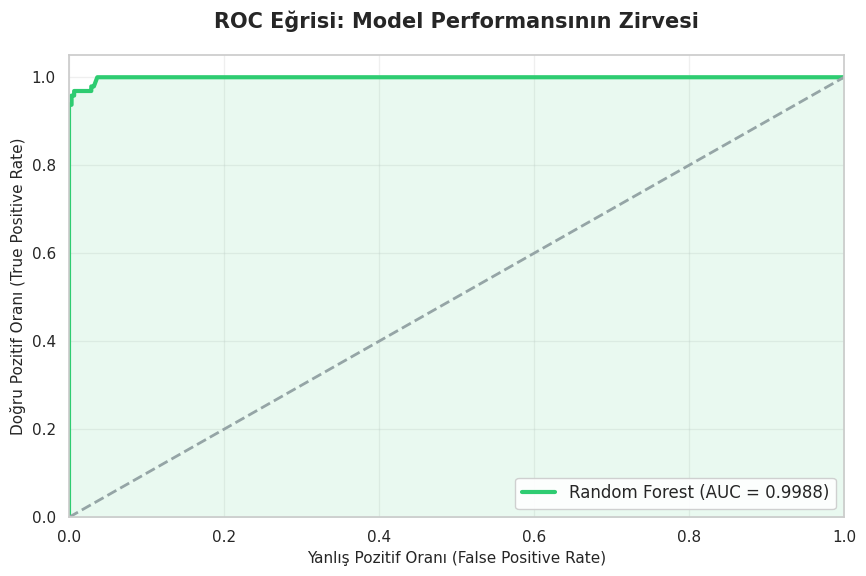

In [76]:
# 1. TAHMİN OLASILIKLARI
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# 2. ROC EĞRİSİ HESAPLAMA
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 3. GÖRSELLEŞTİRME
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#2ECC71', lw=3, label=f'Random Forest (AUC = {roc_auc:.4f})') # Zümrüt Yeşili
plt.plot([0, 1], [0, 1], color='#95A5A6', lw=2, linestyle='--') # Rastgele Tahmin Çizgisi (Gri)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)', fontsize=11)
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)', fontsize=11)
plt.title('ROC Eğrisi: Model Performansının Zirvesi', fontsize=15, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12, frameon=True, facecolor='white', framealpha=0.9)

plt.fill_between(fpr, tpr, alpha=0.1, color='#2ECC71')
plt.grid(True, alpha=0.3)

plt.show()

30 Günlük Simülasyon Ortalaması: 329,467 TL


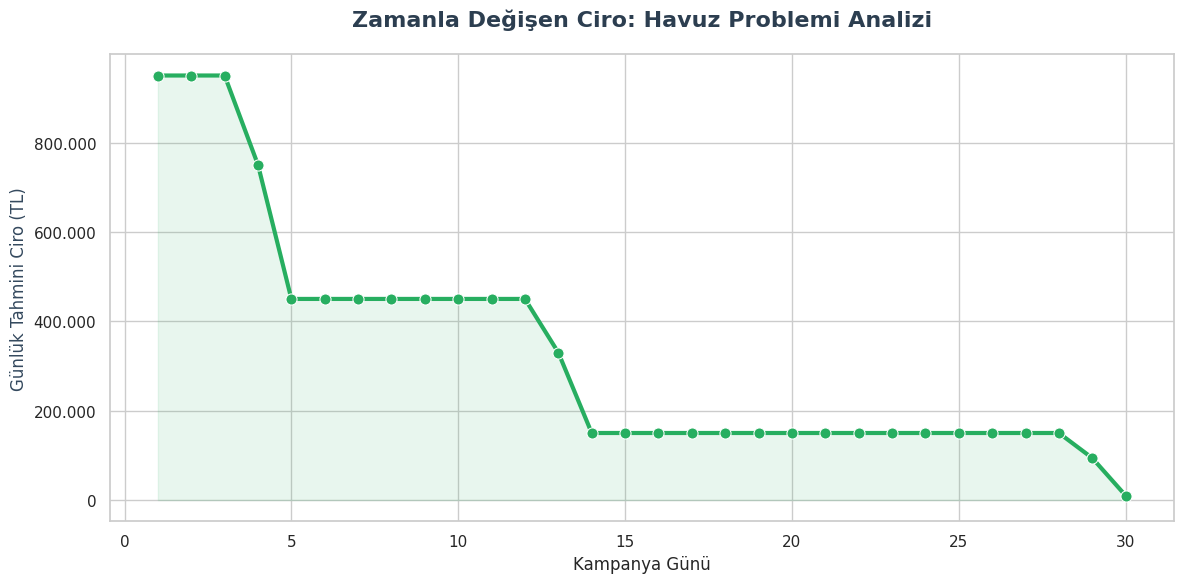

In [82]:
# HAVUZ PROBLEMİ

# 1. SİMÜLASYON PARAMETRELERİ
GUNLUK_ARAMA_KAPASITESI = 50
SATIS_BASINA_GELIR = 20000  # TL

# Müşteri Segmentlerini Tanımlama
# Sayılar: Veri setindeki oranlara göre tahmini havuz büyüklükleri
# Oranlar: Modelin o segmentteki başarı ihtimali
segmentler = [
    {'isim': '1. Platinum (CD Hesap + Yüksek Gelir)', 'kisi_sayisi': 180,  'basari_orani': 0.95}, # %95 Başarı
    {'isim': '2. Gold (Yüksek Gelir + Eğitim)',       'kisi_sayisi': 450,  'basari_orani': 0.45}, # %45 Başarı
    {'isim': '3. Silver (Sadece Yüksek Gelir)',       'kisi_sayisi': 800,  'basari_orani': 0.15}, # %15 Başarı
    {'isim': '4. Bronze (Genel Kitle)',               'kisi_sayisi': 3570, 'basari_orani': 0.01}  # %1 Başarı
]

# 2. GÜNLÜK SİMÜLASYON DÖNGÜSÜ
sonuclar = []
gun = 1
aktif_segment_indeksi = 0

# 30 Günlük bir kampanya simülasyonu
for _ in range(30):
    kalan_arama_hakki = GUNLUK_ARAMA_KAPASITESI
    gunluk_satis_adedi = 0
    bugun_aranan_segmentler = set()

    # Günlük 50 aramayı doldurana kadar segmentlerden kişi seç
    while kalan_arama_hakki > 0 and aktif_segment_indeksi < len(segmentler):
        aktif_segment = segmentler[aktif_segment_indeksi]

        if aktif_segment['kisi_sayisi'] > 0:
            aranacak_kisi = min(kalan_arama_hakki, aktif_segment['kisi_sayisi'])
            satis = aranacak_kisi * aktif_segment['basari_orani']
            gunluk_satis_adedi += satis

            aktif_segment['kisi_sayisi'] -= aranacak_kisi
            kalan_arama_hakki -= aranacak_kisi
            bugun_aranan_segmentler.add(aktif_segment['isim'].split('.')[1]) # İsim kısmını al
        else:
            # Bu havuz bitti, sıradakine geç (Örn: Platinum bitti, Gold'a geç)
            aktif_segment_indeksi += 1

    gunluk_ciro = gunluk_satis_adedi * SATIS_BASINA_GELIR
    sonuclar.append({
        'Gün': gun,
        'Tahmini Ciro': gunluk_ciro,
        'Aktif Segment': ', '.join(bugun_aranan_segmentler) if bugun_aranan_segmentler else 'Havuz Tükendi'
    })
    gun += 1

df_simulasyon = pd.DataFrame(sonuclar)

# 3. ORTALAMA CİRO HESABI
ortalama_ciro = df_simulasyon['Tahmini Ciro'].mean()
print(f"30 Günlük Simülasyon Ortalaması: {ortalama_ciro:,.0f} TL")


# 4. GÖRSELLEŞTİRME
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Çizgi Grafik
ax = sns.lineplot(x='Gün', y='Tahmini Ciro', data=df_simulasyon,
                  linewidth=3, color='#27AE60', marker='o', markersize=8)

plt.fill_between(df_simulasyon['Gün'], df_simulasyon['Tahmini Ciro'], color='#27AE60', alpha=0.1)

plt.title('Zamanla Değişen Ciro: Havuz Problemi Analizi', fontsize=16, fontweight='bold', pad=20, color='#2c3e50')
plt.ylabel('Günlük Tahmini Ciro (TL)', fontsize=12, color='#34495e')
plt.xlabel('Kampanya Günü', fontsize=12)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', '.')))

ilk_gun_ciro = df_simulasyon.iloc[0]['Tahmini Ciro']

plt.tight_layout()
plt.show()